# UNIVERSIDADE FEDERAL DO RIO DE JANEIRO

### Trabalho de Conclusão da Disciplina Mineração de Dados (MAB532)

 **Integrante(s)**

>Eduardo Fernando dos Santos Araujo

>Renan Ferreira de Lima

>Vinicius Almeida Alves


**Graduação(ões)** 

>Engenharia de Computação e Informação

>Bacharelado em Ciências e Matemáticas da Terra (BCMT)

>Engenharia de Computação e Informação

**DRE(s)**

>113049268

>116118058

>111276908

**Prof:** Jonice

*OBS: A(s) graduação(ões) e o(s) DRE(s) está(ão) ordenada(s) de acordo com o(s) integrante(s), ou seja, o primeiro integrante possui a primeira graduação e o primeiro DRE*

# Introdução

Ao vender produtos usados online, uma combinação de detalhes minúsculos e diferenciados na descrição de um produto pode fazer uma grande diferença em aumentar os interesses dos clientes. E, mesmo com uma lista otimizada de produtos, a demanda por um produto pode simplesmente não existir. Vendedores que realizam grandes investimentos em anúncios dos seus produtos podem muitas vezes não ter o retorno esperado, fazendo que eles fiquem frustrados.

O Avito, o maior site de anúncios classificados da Rússia, está profundamente familiarizado com este problema. Os vendedores em sua plataforma às vezes se sentem frustrados com as poucas vendas, indicando que no anúncio falta algo para que possa tornar-se um sucesso ou mesmo com muitas vendas, onde é possível que um produto esteja sendo vendido por um preço mais baixo do que poderia, fazendo com que o potencial da venda não alcance seu máximo.

Afim de resolver esse problema, foi criado uma competição no Kaggle, da qual estamos participando, que busca uma forma de previsão e análise do anúncio de cada vendedor, para que possa se calcular a probabilidade do item ser vendido ou não. Fazendo com que os investimentos em anúncios, por parte dos vendedores, possa ser feito de forma mais eficiente e lucrativa.

# Imports

In [1]:
import textblob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from IPython.display import display_html
from tqdm import tqdm,tqdm_pandas

# Analise dos dados

Faremos primeiramente uma breve análise dos dados do dataset de treino. Trata-se de um dataset com 1503424 registros e 18 colunas, com seus respectivos tipos descritos abaixo.

In [2]:
# Leitura dos dados do dataset
data = pd.read_csv('data/train.csv', encoding='utf8',  parse_dates=["activation_date"])    

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim

## Eliminando coluna desnecessária

Optamos por eliminar uma coluna que certamente não influencia a probabilidade de sucesso de um anúncio, a de identificadores dos items, gerados automaticamente pela plataforma. Podemos então verificar como esses dados estão dispostos, utilizando uma função do Pandas que permite exibir as primeiras linhas de um DataFrame.

In [3]:
columns_to_drop =['item_id']
data.drop(columns=columns_to_drop, inplace=True)
# Transforma a coluna 'image_top_1' para str
data['image_top_1'] = data['image_top_1'].astype(str)
data.head(5)

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


## Período de geração dos dados

O dataset registra anúncios criados de 15 de março de 2017 até 7 de abril do mesmo ano, como mostrado no gráfico abaixo. Observa-se que o dia da ativação do anúncio não teve grande impacto sobre a probabilidade de efetivação da venda durante o mês de março, porém nota-se um aumento dessa probabilidade, em média, durante o mês de abril.

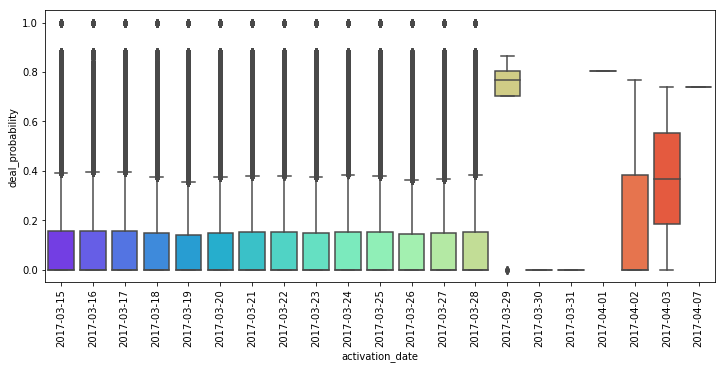

In [4]:
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.boxplot(x=data.sort_values('activation_date')['activation_date'].dt.date, y='deal_probability', data= data, palette='rainbow')
plt.show()

# Colunas Númericas

Pela análise dos gráficos, podemos observar que não há uma correlação entre a probabilidade de efetivação do negócio e o preço anunciado, nem com o número de sequência do item, dado que os valores são muito próximas de 0.  

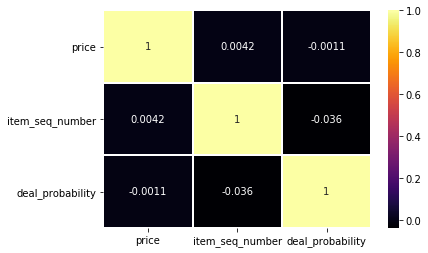

In [13]:
corr = data.corr()
sns.heatmap(corr, cmap = 'inferno', annot=True,linewidths=1)
plt.show()

Mostra-se os dados estatísticos descritivos dessas colunas. Nota-se que a probabilidade de venda do anúncio é, em média, abaixo de 15%, onde pelo menos 50% dos anúncios desse dataset têm esta probabilidade igualada a 0. Pela análise dos quartis, podemos notar que a média da coluna preço está muito alta em relação ao totalidade dos dados, havendo a presença de um ou mais outliers, como o de valor máximo 79501011850.00. Algo semelhante ocorre para a coluna de número de sequência dos itens do usuário.

,price,item_seq_number,deal_probability
count,1418062.00,1503424.00,1503424.00
mean,316708.09,743.67,0.14
std,66891542.10,5572.52,0.26
min,0.00,1.00,0.00
25%,500.00,9.00,0.00
50%,1300.00,29.00,0.00
75%,7000.00,88.00,0.15
max,79501011850.00,204429.00,1.00


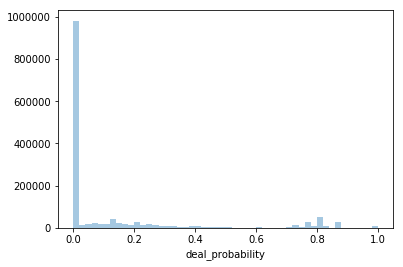

In [25]:
pd.options.display.float_format = "{:.2f}".format
display(data.describe())
sns.distplot(data.deal_probability.values, kde = False, axlabel = 'deal_probability')
plt.show()


## Traduzindo Colunas Categóricas

Nota-se que os dados do dataset são todos em russo, uma linguagem que nós desconhecemos, o que dificultaria uma análise mais transparente nessa etapa do trabalho. Portanto, decidimos, para esta etapa, traduzir os dados das colunas categóricas para o inglês, utilizando a bilioteca de processamento de texto TextBlob.

In [4]:
# Função para traduizir o texto para o Inglês
def translate(x):
    try:
        return ''.join(textblob.TextBlob(x).translate(to="en"))
    except:
        return x

columns_to_translate = ["region","city","parent_category_name","category_name","param_1","param_2","param_3"]
    
for column in columns_to_translate:
    columnGroups = pd.Series(list(data.groupby(column).groups))
    columnGroupsEN=map(translate, columnGroups)
    dictionaryGroupsTranslate = dict(zip(list(columnGroups), list(columnGroupsEN)))
    data[column] = pd.Series(list(str(dictionaryGroupsTranslate.get(word, word)) for word in data[column]))

data.head(15)

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,e00f8ff2eaf9,Sverdlovsk region,Ekaterinburg,Personal things,Goods for children and toys,Bed dress,nan,nan,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,39aeb48f0017,Samara Region,Samara,For home and cottages,Furniture and interior,Other,nan,nan,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,91e2f88dd6e3,Rostov region,Rostov-na-Donu,Consumer electronics,Audio and video,"Video, DVD and Blu-ray players",nan,nan,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,bf5cccea572d,Tatarstan,Naberezhnye Chelny,Personal things,Goods for children and toys,Car seats,nan,nan,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,ef50846afc0b,Volgograd region,Volgograd,Transport,Cars,With mileage,VAZ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797
5,bbfad0b1ad0a,Tatarstan,Chistopol,Personal things,Goods for children and toys,Car seats,nan,nan,Авто люлька,В хорошем состоянии,1300.0,9,2017-03-28,Private,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,796.0,0.80323
6,08f469d2e6f7,Nizhny Novgorod Region,Nizhny Novgorod,For home and cottages,Repair and construction,Plumbing and sauna,nan,nan,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,11000.0,125,2017-03-23,Private,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.0,0.00000
7,fef86baa002c,Perm Region,Permian,Personal things,"Clothes, shoes, accessories",Women's clothing,Jeans,26,Бойфренды colins,Бойфренды в хорошем состоянии.,500.0,61,2017-03-25,Private,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,567.0,0.80323
8,055825270190,Orenburg region,Orenburg,Personal things,"Clothes, shoes, accessories",Women's clothing,Dresses and skirts,> 50 (XXL),Платье,54 раз мер очень удобное,500.0,85,2017-03-17,Private,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,415.0,0.00000
9,f9e8f831d94c,Nizhny Novgorod Region,Nizhny Novgorod,Personal things,Children's clothing and footwear,For girls,Footwear,25,Полу ботиночки замш натур.Бамбини,По стельке 15.5см мерить приокский район. Цвет...,400.0,136,2017-03-22,Company,54fb8521135fda77a860bfd2fac6bf46867ab7c06796e3...,46.0,0.00000


Pudemos perceber que há 3 tipos de usuários: 'Private', 'Company' e 'Shop'; e que a grande maioria dos anúncios publicados são de usuários do tipo 'Private'. Observamos também que não há uma diferença estatísticamente considerável entre a probabilidade de sucesso de anúncios entre os tipos 'Private' e 'Company', porém essa probabilidade tende a ser menor, em média, para usuários do tipo 'Shop'.

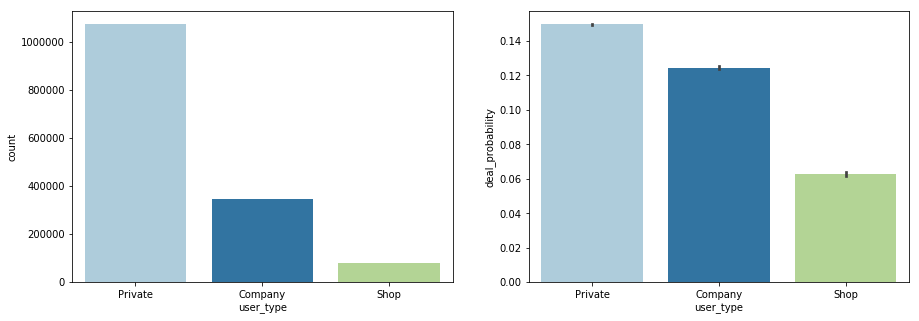

In [14]:
fig, axs = plt.subplots(ncols=2, sharey='col', figsize=(15,5))
sns.countplot(x="user_type", palette='Paired',data=data, ax=axs[0])
sns.barplot(x='user_type',  y='deal_probability', palette='Paired', data=data, ax=axs[1])
plt.show()


Obeserva-se nos gŕaficos abaixo, que a maioria das propagandas criadas durante esse período foram anúncios de produtos pessoais. Focando especificamente em roupas e acessórios, tanto para adultos quanto para crianças, obtemos, com as duas categorias juntas, quase 40% do número total de anúncios.

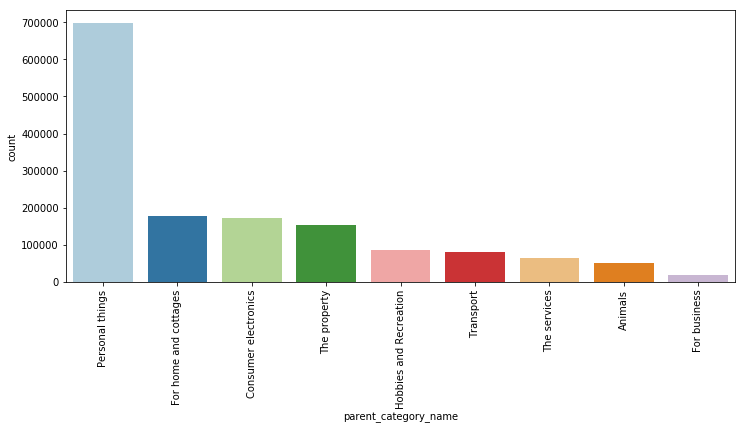

In [15]:
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.countplot(x='parent_category_name', data=data, order = data["parent_category_name"].value_counts().index, palette='Paired' )
plt.show()

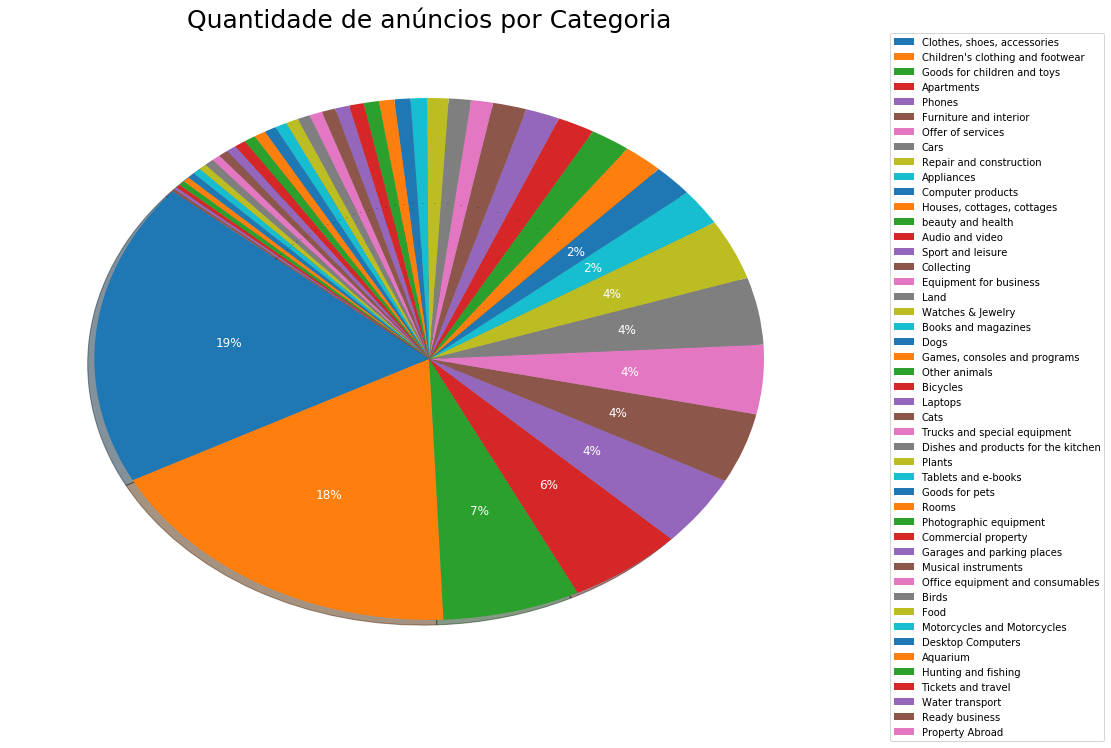

In [16]:
fig = plt.figure( figsize = (15,12))
ax = fig.add_subplot( 1, 1, 1 )
patches, texts,autotexts = plt.pie(data["category_name"].value_counts().values,
        shadow=True, startangle=140, autopct='%.0f%%')
plt.legend(patches, data["category_name"].value_counts().index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i in range(0, len(data["category_name"].value_counts())):
    if(i<=10):
        autotexts[i].set_size('large')
        autotexts[i].set_color('w')
    else:
        autotexts[i].set_size(0)
plt.title('Quantidade de anúncios por Categoria', fontsize= 25)
plt.show()


Entretanto, não são os anúncios de produtos pessoais que possuem maior probabilidade de sucesso, e sim os de serviços seguidos de anúncios de transporte e animais.

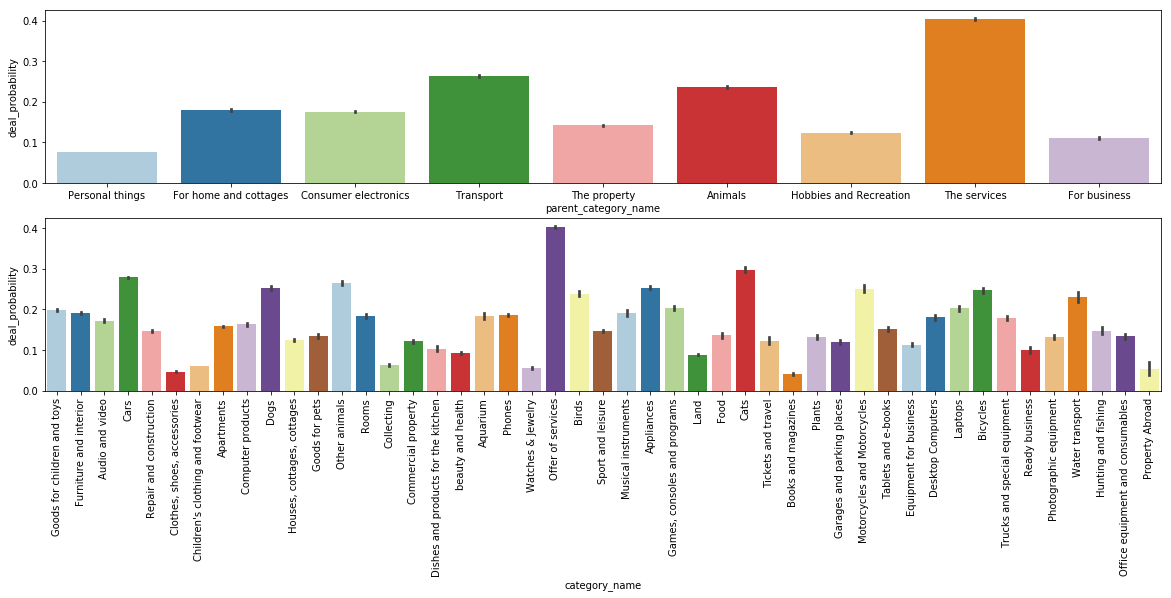

In [17]:
fig, axs = plt.subplots(nrows=2, figsize=(20,7))
sns.barplot(x='parent_category_name',  y='deal_probability', palette='Paired', data=data, ax=axs[0])
sns.barplot(x='category_name',  y='deal_probability', palette='Paired', data=data, ax=axs[1])
plt.xticks(rotation='vertical')
plt.show()


### Média da Probabilidade de Venda para outras variaveis categóricas

Optamos por uma vizualização em tabela de outras variáveis categóricas. Agrupamos as médias de probabilidade de negócio de cada variável, ordenadas da maior para a menor. Notamos que  a variação desses parâmetros possuem, em média, grande impacto na probabilidade de negócio, com exceção da váriavel região, onde não nota-se uma variação relevante da probabilidade de uma região para outra.

In [17]:
# Função auxiliar utilizada para exbir tabelas lado a lado
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

param_1 = data.groupby('param_1').mean().sort_values('deal_probability', ascending=False).head(15).drop(['price','item_seq_number'], axis=1)
param_2 = data.groupby('param_2').mean().sort_values('deal_probability', ascending=False).head(15).drop(['price','item_seq_number'], axis=1)
param_3 = data.groupby('param_3').mean().sort_values('deal_probability', ascending=False).head(15).drop(['price','item_seq_number'], axis=1)

display_side_by_side(param_1,param_2,param_3)


,deal_probability
param_1,
Briar,0.67
Repair and maintenance of machinery,0.57
The Urals Rex,0.55
"Transport, transportation",0.54
"Garden, accomplishment",0.53
Belgian Griffon,0.47
"Nurses, nurse",0.46
Cleaning,0.44
Master for an hour,0.44


In [20]:
region = data.groupby('region').mean().sort_values('deal_probability', ascending=False).drop(['price','item_seq_number'], axis=1)
city = data.groupby('city').mean().sort_values('deal_probability', ascending=False).head(30).drop(['price','item_seq_number'], axis=1)
image_top_1 = data.groupby('image_top_1').mean().sort_values('deal_probability', ascending=False).head(30).drop(['price','item_seq_number'], axis=1)
display_side_by_side(region, city, image_top_1)


,deal_probability
region,
Orenburg region,0.16
Stavropol region,0.15
Bashkortostan,0.15
Udmurtia,0.15
Krasnodar region,0.15
Nizhny Novgorod Region,0.15
Saratov region,0.15
Volgograd region,0.15
Belgorod region,0.15
